In [57]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import copy

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:00<00:00, 28882393.42it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 2035397.03it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 21584114.99it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [6]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [31]:
training_data.classes

# print([_ for _ in range(len(training_data.classes))])

label_mapping = {training_data.classes.index(x):x for x in training_data.classes}

label_mapping

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

Text(0.5, 1.0, 'Sneaker')

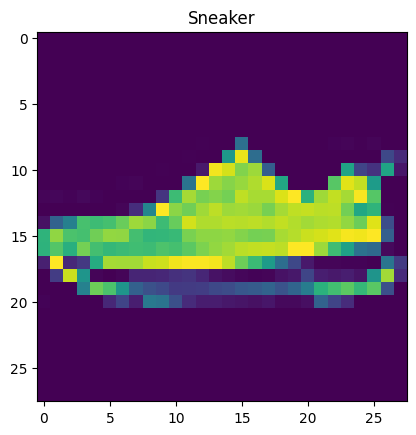

In [32]:
image_tensor, label = next(iter(train_dataloader))
number_index = torch.randint(len(image_tensor), size=(1,)).item()

plt.imshow(image_tensor[number_index].squeeze())
plt.title(label_mapping.get(label[number_index].item()))


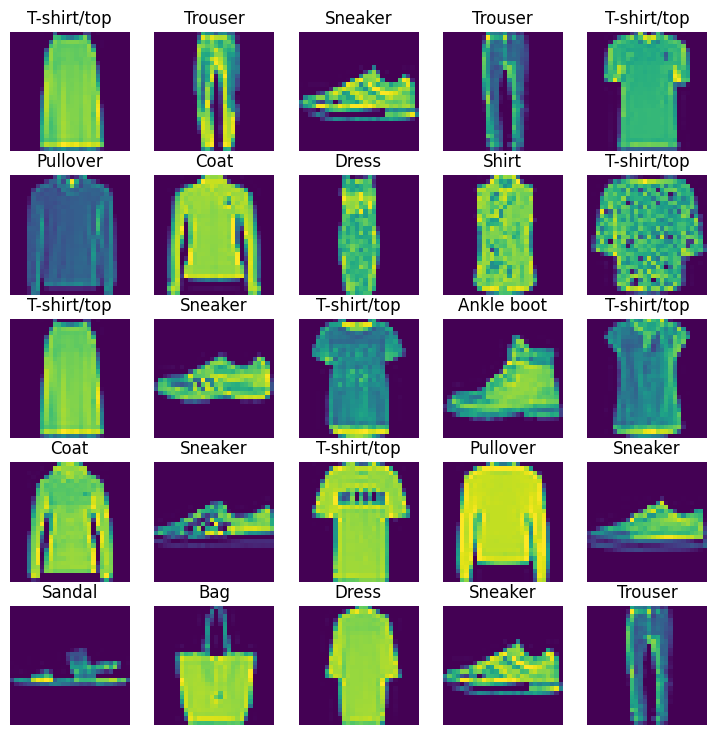

In [40]:
figure = plt.figure(figsize=(9, 9))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    sample_index = torch.randint(len(image_tensor), size=(1,))
    sample_image = image_tensor[sample_index]
    sample_label = label[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(sample_image.squeeze())
    plt.title(label_mapping.get(sample_label.item()))

In [163]:
class FashionNeuralNet(nn.Module):
    def __init__(self, input_shape: int, out_classes: int):
        super().__init__()
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.layer1 = nn.Linear(input_shape, 128)
        self.layer2 = nn.Linear(128, 512)
        self.layer3 = nn.Linear(512, 1024)
        self.layer4 = nn.Linear(1024, out_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        return x

In [164]:
model = FashionNeuralNet(input_shape=28*28, out_classes=len(label_mapping))

In [165]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr=0.001)

n_epochs = 20
best_weights = None
best_accuracy = -np.inf
accuracy_hist = []
loss_hist = []

In [166]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for train_features, train_labels in (bar:=tqdm(train_dataloader, unit='batch')):
        bar.set_description(f'Epoch: {epoch+1}/{n_epochs}')
        train_features, train_labels = train_features.to(device), train_labels.to(device)
        output = model(train_features)

        loss = loss_fn(output, train_labels)
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        train_loss += loss.item()
        bar.set_postfix(loss=loss.item())
    
    model.eval()
    test_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for test_features, test_labels in (test_bar:=tqdm(test_dataloader, unit='batch')):
            test_bar.set_description(f'Testing for Epoch {epoch+1}')
            test_features, test_labels = test_features.to(device), test_labels.to(device)
            
            output = model(test_features)
            loss = loss_fn(output, test_labels)
            test_loss += loss.item()
            
            
            
            predicted = torch.argmax(output, dim=1)
            total += test_labels.shape[0]
            correct += (predicted == test_labels).sum().item()
            
            
    test_loss /= len(test_dataloader)
    scheduler.step(test_loss)
    loss_hist.append(test_loss)
    accuracy = 100 * correct/total
    
    print(f"Epoch {epoch+1} validation: Cross-entropy={test_loss:.2f}, Accuracy={accuracy:.1f}%, Lr={optimizer.param_groups[0]['lr']:.4f}")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = copy.deepcopy(model.state_dict())
    accuracy_hist.append(accuracy)

Testing for Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 89.05batch/s]


Epoch 1 validation: Cross-entropy=2.28, Accuracy=42.7%, Lr=0.0010


Testing for Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 88.57batch/s]


Epoch 2 validation: Cross-entropy=2.25, Accuracy=51.8%, Lr=0.0010


Testing for Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 84.84batch/s]


Epoch 3 validation: Cross-entropy=2.17, Accuracy=51.5%, Lr=0.0010


Testing for Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 82.14batch/s]


Epoch 4 validation: Cross-entropy=2.00, Accuracy=49.4%, Lr=0.0010


Testing for Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 85.52batch/s]


Epoch 5 validation: Cross-entropy=1.67, Accuracy=48.8%, Lr=0.0010


Testing for Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 86.14batch/s]


Epoch 6 validation: Cross-entropy=1.35, Accuracy=58.0%, Lr=0.0010


Testing for Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 88.42batch/s]


Epoch 7 validation: Cross-entropy=1.15, Accuracy=59.9%, Lr=0.0010


Testing for Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 84.45batch/s]


Epoch 8 validation: Cross-entropy=1.04, Accuracy=61.3%, Lr=0.0010


Testing for Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 87.35batch/s]


Epoch 9 validation: Cross-entropy=0.96, Accuracy=64.1%, Lr=0.0010


Testing for Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 86.58batch/s]


Epoch 10 validation: Cross-entropy=0.90, Accuracy=66.1%, Lr=0.0010


Testing for Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 88.63batch/s]


Epoch 11 validation: Cross-entropy=0.86, Accuracy=67.0%, Lr=0.0010


Testing for Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 83.96batch/s]


Epoch 12 validation: Cross-entropy=0.82, Accuracy=68.8%, Lr=0.0010


Testing for Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 83.68batch/s]


Epoch 13 validation: Cross-entropy=0.80, Accuracy=69.3%, Lr=0.0010


Testing for Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 85.46batch/s]


Epoch 14 validation: Cross-entropy=0.78, Accuracy=70.4%, Lr=0.0010


Testing for Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 83.59batch/s]


Epoch 15 validation: Cross-entropy=0.76, Accuracy=71.5%, Lr=0.0010


Testing for Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 89.62batch/s]


Epoch 16 validation: Cross-entropy=0.74, Accuracy=72.1%, Lr=0.0010


Testing for Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 91.07batch/s]


Epoch 17 validation: Cross-entropy=0.72, Accuracy=73.2%, Lr=0.0010


Testing for Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 88.79batch/s]


Epoch 18 validation: Cross-entropy=0.71, Accuracy=73.9%, Lr=0.0010


Testing for Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 87.89batch/s]


Epoch 19 validation: Cross-entropy=0.69, Accuracy=74.3%, Lr=0.0010


Testing for Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 91.33batch/s]


Epoch 20 validation: Cross-entropy=0.68, Accuracy=75.2%, Lr=0.0010


In [167]:
test_model = FashionNeuralNet(784, 10)
test_model.load_state_dict(best_weights)
test_model.to(device)

FashionNeuralNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=1024, bias=True)
  (layer4): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [168]:
false_data = []
test_model.eval()

for test_image, test_labels in (new_bar:=tqdm(test_dataloader, unit='batch')):
    test_image, test_labels = test_image.to(device), test_labels.to(device)
    output = test_model(test_image)
    out_label = torch.argmax(output, dim=1)
    for i in range(len(out_label)):
        if out_label[i] != test_labels[i]:
            false_data.append((test_image[i], test_labels[i], out_label[i]))

100%|██████████| 157/157 [00:02<00:00, 61.63batch/s]


C:\Users\leand\AppData\Local\Temp\ipykernel_9440\2772107606.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


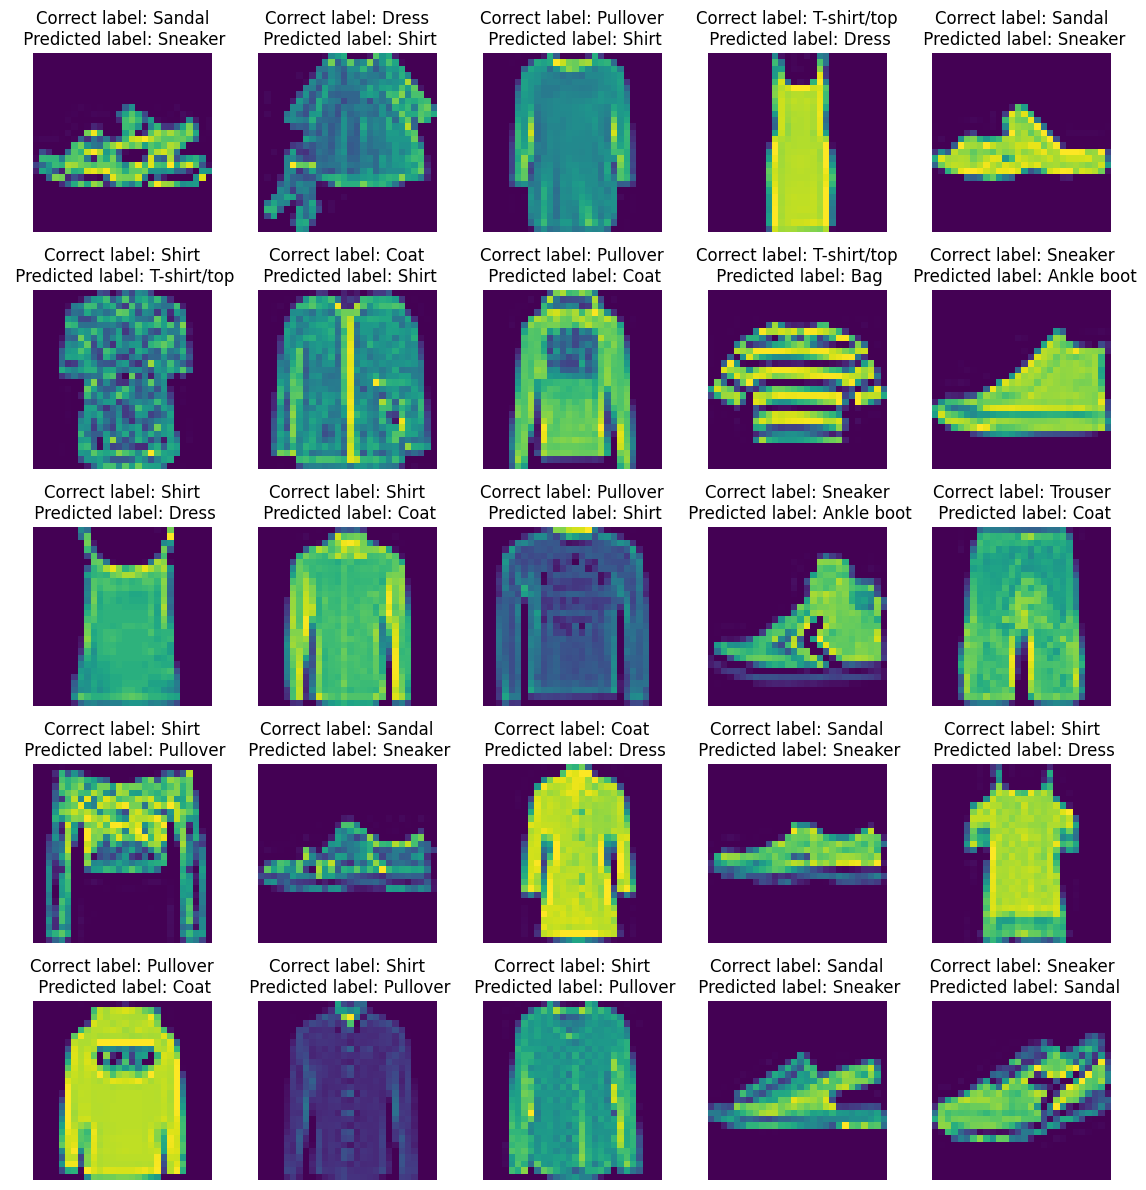

In [169]:
figure = plt.figure(figsize=(12, 12))
cols, rows = 5, 5

for i in range(1, cols*rows+1):
    sample_index = torch.randint(len(false_data), size=(1,))
    sample_image = false_data[sample_index][0].detach().cpu()
    sample_label = false_data[sample_index][1]
    output_label = false_data[sample_index][2]
    figure.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(sample_image.squeeze())
    plt.tight_layout()
    plt.title(f'Correct label: {label_mapping.get(sample_label.item())}\n Predicted label: {label_mapping.get(output_label.item())}')